In [1]:
import torch
import torchvision.transforms as T
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt # for plotting
import torch # PyTorch package
import torchvision # load datasets
from patchify import patchify
from sklearn.decomposition import PCA

In [2]:
patch_h = 40
patch_w = 40
# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
# feat_dim = 1024 # vitl14
feat_dim = 1536 # vitg14

# dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
# dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
print(dinov2_vitg14)

# Caltech101 Dataset Preprocessing
transform = T.Compose([
    T.GaussianBlur(9, sigma=(0.1, 2.0)),
    T.Resize((patch_h * 14, patch_w * 14)),
    T.CenterCrop((patch_h * 14, patch_w * 14)),
    T.ToTensor(),
    #T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# set batch_size
batch_size = 1
# set number of workers
num_workers = 1

# load train data
trainset = torchvision.datasets.Caltech101(root='./data', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Using cache found in /Users/ashwin/.cache/torch/hub/facebookresearch_dinov2_main
/Users/ashwin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/ashwin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/ashwin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [4]:
# Removing the Irrelevant category
classes = [d.name for d in os.scandir(os.path.join('./data', 'caltech101', '101_ObjectCategories')) if d.is_dir()]
classes.remove('BACKGROUND_Google')
classes.sort()         

In [5]:
# Algorithm that splits an image into patches
def get_patches(image):
    patches = patchify(image.numpy(), (560,560,3), step=560)
    patches = torch.from_numpy(patches)
    return torch.squeeze(patches)

In [69]:
# Checking the shape of a patch
with torch.no_grad():
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        print(classes[labels])
        inputs = torch.nn.functional.interpolate(inputs, scale_factor=2, mode='bilinear', align_corners=False)
        patches = get_patches(torch.permute(torch.squeeze(inputs), (1,2,0)))
        print(patches.shape)
        break

starfish
torch.Size([2, 2, 560, 560, 3])


torch.Size([560, 560, 3])
torch.Size([560, 560, 3])
torch.Size([560, 560, 3])
torch.Size([560, 560, 3])


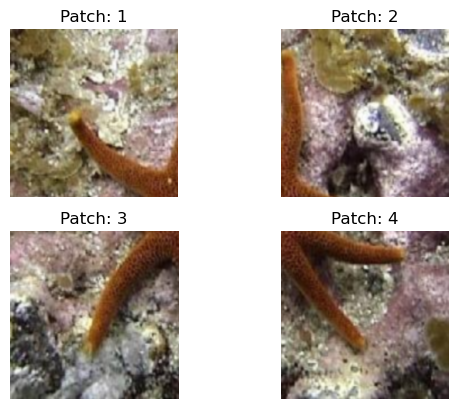

In [70]:
# Selecting a random patch
fig, axs = plt.subplots(2,2)
m=0
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        im = patches[i][j]
        print(im.shape)
        axs[i][j].imshow((im.detach().cpu().numpy()))
        axs[i][j].set_title("Patch: "+str(m+1))
        axs[i][j].axis('off')
        m+=1
plt.show()

In [71]:
# Calculating Dinov2 embeddings for the selected patch
features = torch.zeros(4, patch_h * patch_w, feat_dim)
imgs_tensor = torch.zeros(4, 3, patch_h * 14, patch_w * 14)
i=0
for r in range(patches.shape[0]):
    for c in range(patches.shape[1]):
        imgs_tensor[i] = torch.permute(patches[r][c], (2,0,1))
        i+=1
with torch.no_grad():
    print(imgs_tensor.shape)
    features_dict = dinov2_vitg14.forward_features(imgs_tensor)
    features = features_dict['x_norm_patchtokens']

print(features_dict.keys())
print(features.shape)
features = features.reshape(4 * patch_h * patch_w, feat_dim)
print(features.shape)

torch.Size([4, 3, 560, 560])
dict_keys(['x_norm_clstoken', 'x_norm_regtokens', 'x_norm_patchtokens', 'x_prenorm', 'masks'])
torch.Size([4, 1600, 1536])
torch.Size([6400, 1536])


In [72]:
# Initialising and transforming the features using PCA
pca = PCA(n_components=3)
pca.fit(features)
pca_features = pca.transform(features)
pca_features.shape

(6400, 3)

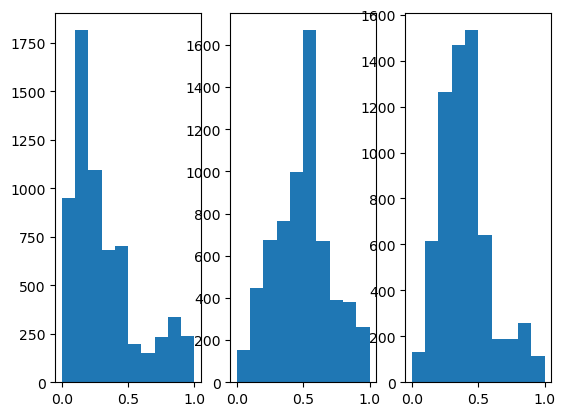

In [74]:
# Normalising the PCA components
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / (pca_features[:, 0].max() - pca_features[:, 0].min())
pca_features[:, 1] = (pca_features[:, 1] - pca_features[:, 1].min()) / (pca_features[:, 1].max() - pca_features[:, 1].min())
pca_features[:, 2] = (pca_features[:, 2] - pca_features[:, 2].min()) / (pca_features[:, 2].max() - pca_features[:, 2].min())

# visualize PCA components for finding a proper threshold
plt.subplot(1, 3, 1)
plt.hist(pca_features[:, 0])
plt.subplot(1, 3, 2)
plt.hist(pca_features[:, 1])
plt.subplot(1, 3, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

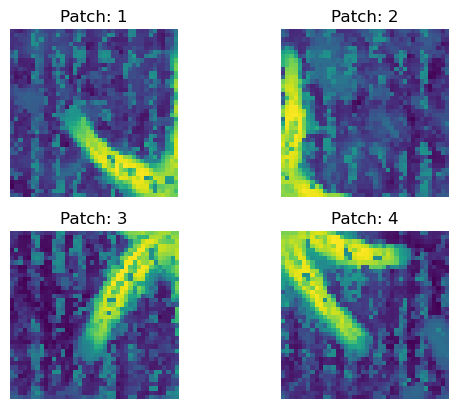

In [75]:
# To plot the first pca component
fig, axs = plt.subplots(2,2)
i=0
for m in range(2):
    for n in range(2):
        axs[m][n].imshow(pca_features[i * patch_h * patch_w: (i+1) * patch_h * patch_w, 0].reshape(patch_h, patch_w))
        axs[m][n].set_title("Patch: "+str(i+1))
        axs[m][n].axis('off')
        i+=1
plt.show()

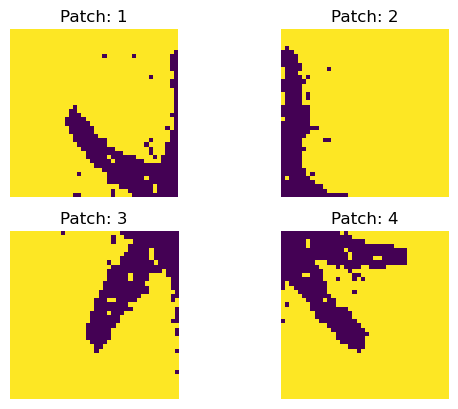

In [77]:
# segment using the first component
pca_features_bg = pca_features[:, 0] < 0.5
pca_features_fg = ~pca_features_bg
fig, axs = plt.subplots(2,2)

# plot the pca_features_bg
i=0
for m in range(2):
    for n in range(2):
        axs[m][n].imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
        axs[m][n].set_title("Patch: "+str(i+j))
        axs[m][n].axis('off')
        i+=1
plt.show()


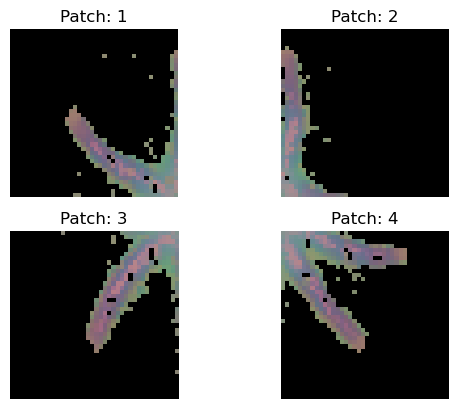

In [78]:
# PCA for only foreground patches
pca.fit(features[pca_features_fg]) 
pca_features_rem = pca.transform(features[pca_features_fg])
for i in range(3):
    # pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())
    # transform using mean and std, I personally found this transformation gives a better visualization
    pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].mean()) / (pca_features_rem[:, i].std() ** 2) + 0.5

pca_features_rgb = pca_features.copy()
pca_features_rgb[pca_features_bg] = 0
pca_features_rgb[pca_features_fg] = pca_features_rem

pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)

fig, axs = plt.subplots(2,2)
i=0
for m in range(2):
    for n in range(2):
        axs[m][n].imshow(pca_features_rgb[i][..., ::-1])
        axs[m][n].set_title("Patch: "+str(i+j))
        axs[m][n].axis('off')
        i+=1
#plt.savefig('features.png')
plt.show()